## Import Libraries and Data

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [24]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data exploration

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [48]:
target_variable = 'SalePrice'

## Variables Correlation

#### Distribution of target variable

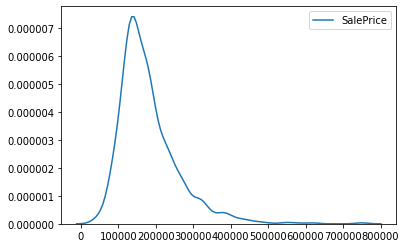

In [6]:
sns.kdeplot(train[target_variable])

#### Check the correlation of variables

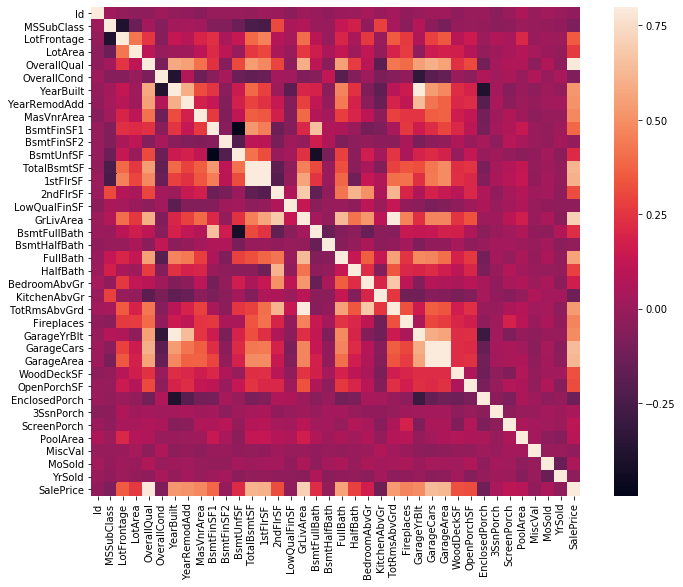

In [7]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

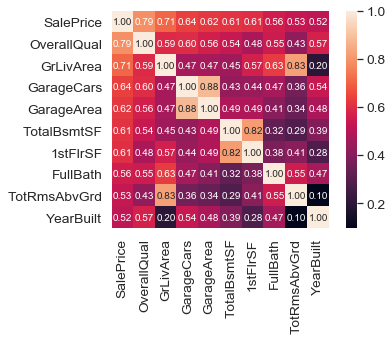

In [8]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, target_variable)[target_variable].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Relation between Living Area and Sales Price

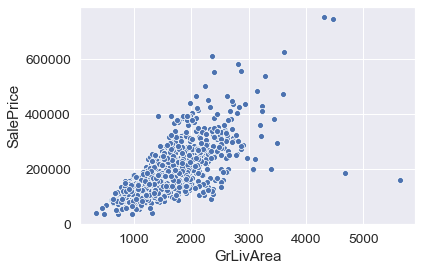

In [9]:
sns.scatterplot(train['GrLivArea'],train[target_variable])

#### Relation between Overall material and finish quality and Sales Price

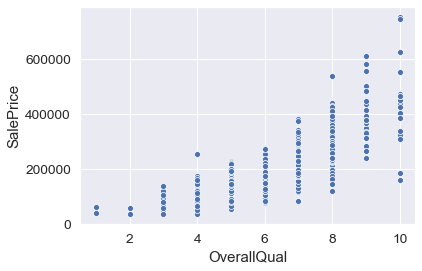

In [10]:
sns.scatterplot(train['OverallQual'],train[target_variable])

## Missing Values

In [11]:
# Drop any column with more than 10% missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [25]:
cols_to_del = ['PoolQC','MiscFeature','Alley','Fence','LotFrontage']

In [51]:
#Delete columns in dataset
filtered_columns = [col for col in train.columns if col not in cols_to_del]
train_ft = train[filtered_columns]

## Preparing dataset for regression

#### Filling null values

In [52]:
train_ft = train_ft.fillna(train_ft.median())

#### Transforming categorical variables in dummy variables

In [53]:
train_ft = pd.get_dummies(train_ft)

#### Train and test split for the train dataset

In [54]:
independent_variables = [col for col in train_ft.columns if col != target_variable]
X_train, X_test, y_train, y_test = train_test_split(train_ft[independent_variables], train_ft[target_variable], test_size=0.2, random_state=0)

#### Feature scaling

In [55]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Regression

#### Training the algorithm

In [56]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

#### Evaluate the regression

In [57]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 18073.60325342466
Mean Squared Error: 1276142850.2482104
Root Mean Squared Error: 35723.14166262831


## Run algorithm os test dataset

#### Prepare test dataset for the regression

In [69]:
#Transform categorical in dummy variables
test_ft = pd.get_dummies(test)

#Fill null values
test_ft = test_ft.fillna(test_ft.median())

#Select only the columns in the training dataset
ind_var_is_test = [col for col in independent_variables if col in test_ft.columns]
ind_var_is_not_test = [col for col in independent_variables if col not in test_ft.columns]
test_ft = test_ft[ind_var_is_test]
for col in ind_var_is_not_test:
    test_ft[col] = 0

#Apply the standard scaler for the test dataset
test_ft = sc.fit_transform(test_ft)

In [72]:
pred = regressor.predict(test_ft)

In [75]:
test['Id']

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [77]:
submission

,Id,SalePrice
0,1461,135245.00
1,1462,156732.50
2,1463,198250.00
3,1464,183320.00
4,1465,204360.00
5,1466,188205.00
6,1467,164655.00
7,1468,173335.00
8,1469,179138.75
9,1470,118998.80


In [78]:
submission = pd.DataFrame(test['Id'])
submission['SalePrice'] = pred
submission.to_csv('submission.csv', index=False)